# HOMEWORK 5 - GENDER INCOME GAP
___
# Author: Arno Amabile

### 1 - Set up the datasets

In [1]:
import pandas as pd
import sys
import os
import numpy 
import pylab as pl
import json
import os
import xlrd
import statsmodels.formula.api as smf
import scipy.stats as stats
s = json.load( open(os.getenv('PUI2015')+"/fbb_matplotlibrc.json") )
pl.rcParams.update(s)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Url to get data
url="http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/"

# Data for Males in a dictionary
allmales={}
allmales['All']=pd.read_excel(url+'/pinc08_2_1_1.xls',header=9)
allmales['White']=pd.read_excel(url+'/pinc08_2_1_4.xls', header=9)
allmales['Black']=pd.read_excel(url+'/pinc08_2_1_6.xls', header=9)
allmales['Hispanic']=pd.read_excel(url+'/pinc08_2_1_9.xls', header=9)
allmales['Asian']=pd.read_excel(url+'/pinc08_2_1_8.xls', header=9)

# Data for Females in a dictionary
allfemales={}
allfemales['All']=pd.read_excel(url+'/pinc08_3_1_1.xls', header=9)
allfemales['White']=pd.read_excel(url+'/pinc08_3_1_4.xls', header=9)
allfemales['Black']=pd.read_excel(url+'/pinc08_3_1_6.xls', header=9)
allfemales['Hispanic']=pd.read_excel(url+'/pinc08_3_1_9.xls', header=9)
allfemales['Asian']=pd.read_excel(url+'/pinc08_3_1_8.xls', header=9)

### 2 - Exploratory phase

Even with the correction of the non numerical entries in the datasets, the scatter matrix would not be helpful here: we are not trying to understand the correlation between the different columns of "allmales" for instance, as they are only counts, for a given source of income, the number of males earning an income within a range (or the median income). Moreover, there are 49 columns, so 49\*49 combinations. The matrix is therefore very long to compute, and unreadable.

In [ ]:
#from pandas.tools.plotting import scatter_matrix
#scatter_matrix(allmales, s=300, figsize=(16, 16), diagonal='kde')

In [3]:
# As scatter matrix is not meaningful, get the columns
print allmales['All'].columns

Index([      u'Characteristic',    u'Total with Income',
       u'$1 to $2,499 or loss',     u'$2,500 to $4,999',
           u'$5,000 to $7,499',     u'$7,500 to $9,999',
         u'$10,000 to $12,499',   u'$12,500 to $14,999',
         u'$15,000 to $17,499',   u'$17,500 to $19,999',
         u'$20,000 to $22,499',   u'$22,500 to $24,999',
         u'$25,000 to $27,499',   u'$27,500 to $29,999',
         u'$30,000 to $32,499',   u'$32,500 to $34,999',
         u'$35,000 to $37,499',   u'$37,500 to $39,999',
         u'$40,000 to $42,499',   u'$42,500 to $44,999',
         u'$45,000 to $47,499',   u'$47,500 to $49,999',
         u'$50,000 to $52,499',   u'$52,500 to $54,999',
         u'$55,000 to $57,499',   u'$57,500 to $59,999',
         u'$60,000 to $62,499',   u'$62,500 to $64,999',
         u'$65,000 to $67,499',   u'$67,500 to $69,999',
         u'$70,000 to $72,499',   u'$72,500 to $74,999',
         u'$75,000 to $77,499',   u'$77,500 to $79,999',
         u'$80,000 to $82,499',

In [4]:
# Remove non number entries for males
for k in allmales:
    nonreal  = allmales[k].applymap(np.isreal)
    for c in allmales[k].columns :
        if nonreal.sum()[c]>1 and nonreal.sum()[c]<49:
            allmales[k][c][~nonreal[c]] = np.float('NaN')
            allmales[k][c] = allmales[k][c].astype(float)
            
# Remove non-number entries for females
for k in allfemales:
    nonreal  = allfemales[k].applymap(np.isreal)
    for c in allfemales[k].columns :
        if nonreal.sum()[c]>1 and nonreal.sum()[c]<49:
            allfemales[k][c][~nonreal[c]] = np.float('NaN')
            allfemales[k][c] = allfemales[k][c].astype(float)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### 3 - Males and Females Median Incomes

In [5]:
# I create another df not necessary for the scatter plot, but useful for the ols model
Races = ['All', 'White', 'Black', 'Hispanic', 'Asian']

medinc = {'Female':[1]*len(Races), 'Male':[1]*len(Races), 'Race':Races}
for i,race in enumerate(Races):
    medinc['Female'][i] = allfemales[race]['Median income'][allfemales[race]['Characteristic'] == '..Wages and Salary'].mean()
    medinc['Male'][i] = allmales[race]['Median income'][allmales[race]['Characteristic'] == '..Wages and Salary'].mean()
    
medinc_df = pd.DataFrame(medinc)

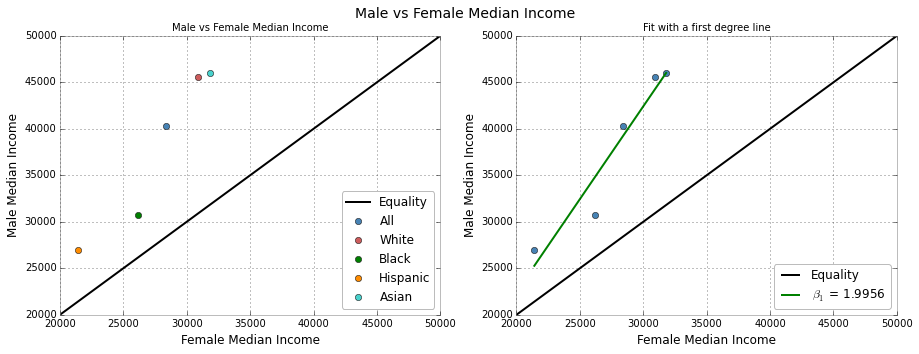

In [6]:
# Set up the figure
fig1 = pl.figure(figsize=(15,5))
fig1.suptitle("Male vs Female Median Income", fontsize=14)

# First plot: median incomes by race
byrace = fig1.add_subplot(121)
byrace.plot([20000,50000],[20000,50000], 'k', label='Equality')
for race in Races:
    byrace.plot(allfemales[race]['Median income'][allfemales[race]['Characteristic'] == '..Wages and Salary'],
                allmales[race]['Median income'][allmales[race]['Characteristic'] == '..Wages and Salary'],
                'o', label=race)
    
byrace.legend(loc=4, numpoints=1) # Numpoints otherwise the legend has 3 dots
byrace.set_xlabel('Female Median Income')
byrace.set_ylabel('Male Median Income')
byrace.set_title('Male vs Female Median Income', fontsize=10)

# Create a support for the prediction with the ols
x = pd.DataFrame({'Female': np.linspace(medinc_df.Female.min(),
                                        medinc_df.Female.max(), 100)})

# Fit with a first degree line
fit = fig1.add_subplot(122)
fit.plot([20000,50000],[20000,50000], 'k', label='Equality')

poly_1 = smf.ols(formula='Male ~ Female', data=medinc_df).fit()
fit.plot(medinc_df.Female, medinc_df.Male, 'o')
fit.plot(x, poly_1.predict(x), 'g-', label=r"$\beta_1$ = {0:.4f}".format(poly_1.params[1]))

fit.legend(loc=4)
fit.set_xlabel("Female Median Income")
fit.set_ylabel("Male Median Income")
fit.set_title("Fit with a first degree line", fontsize=10)

**Figure 1.** Male vs. Female Median Income, by race. Median income is around \$31,000 for black males, and around \$26,000 for black females. In no ethnicity is the male median income lower than the female median income

### 4 - Best Analytical fit 

SpearmanrResult(correlation=1.0, pvalue=0.0) 2.0750984502 -19661.8159888


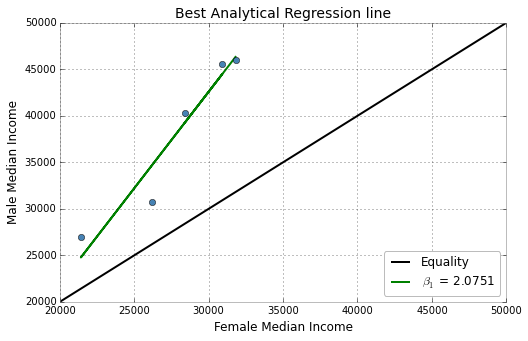

In [7]:
# Compute the coefficients
cor = stats.spearmanr(medinc_df.Male, medinc_df.Female)
beta1=cor[0]*np.std(medinc_df.Male)/np.std(medinc_df.Female)
beta0 = np.mean(medinc_df.Male)-(beta1*np.mean(medinc_df.Female))
print cor, beta1, beta0

# Plot the fit
fig2 = pl.figure(figsize=(8,5))
best = fig2.add_subplot(111)
best.plot([20000,50000],[20000,50000], 'k', label='Equality')
best.plot(medinc_df.Female, beta0 + beta1*medinc_df.Female, 'g-', label=r"$\beta_1$ = {0:.4f}".format(beta1))
best.plot(medinc_df.Female, medinc_df.Male, 'o')

best.legend(loc=4)
best.set_xlabel("Female Median Income")
best.set_ylabel("Male Median Income")
best.set_title("Best Analytical Regression line", fontsize=14)

**Figure 2.** Male vs. Female Median Income. The fit is the best analytical fit computed. It is not notably different from the one computed by Statsmodels. For readability the race colors have been removed, but they are the same as in Fig. 1.

### 5 - Fit comparisons

In [8]:
# Concatenate and flatten the data
all_males=np.ma.array(np.concatenate([allmales['All']['Median income'][:].values,
                                      allmales['White']['Median income'][:].values,
                                      allmales['Black']['Median income'][:].values,
                                      allmales['Hispanic']['Median income'][:].values,
                                      allmales['Asian']['Median income'][:].values]).flatten())

all_females=np.ma.array(np.concatenate([allfemales['All']['Median income'][:].values,
                                        allfemales['White']['Median income'][:].values,
                                        allfemales['Black']['Median income'][:].values,
                                        allfemales['Hispanic']['Median income'][:].values,
                                        allfemales['Asian']['Median income'][:].values]).flatten())

allmask = [np.isnan(all_males) + np.isnan(all_females)]

all_females.mask = allmask
all_males.mask = allmask
all_df = {'Female': all_females, 'Male': all_males}

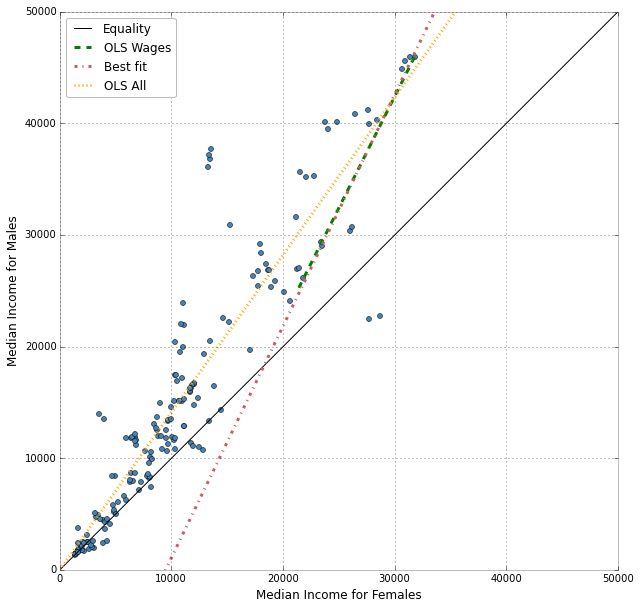

In [9]:
# Plot all the the median incomes, and all the fits

fig3 = pl.figure(figsize=(10,10)) 
ax = fig3.add_subplot(111)

# Plot all the male-female combinations of median incomes
ax.plot(all_females,all_males, 'o',markersize=5)

# Plot the Equal Pay Line
ax.plot([0,50000], [0,50000], 'k', label='Equality', linewidth=1)

# Plot the OLS fit on Median Income for Wages and Salary
ax.plot(x, poly_1.predict(x), 'g-', linestyle='--', label='OLS Wages', linewidth=3)

# Plot the Best Analytical Fit for Wages and Salary
ax.plot([0, 50000], [beta0, 50000*beta1+beta0], linestyle='-.', label = "Best fit", linewidth=3)

# Compute and plot the OLS fit on all categories
poly_2 = smf.ols(formula='Male ~ Female', data=all_df).fit()
ax.plot([0, 50000], [poly_2.params[0], poly_2.params[0] + poly_2.params[1]*50000],linestyle=':',
        label = "OLS All", linewidth=3, color='orange')

ax.set_xlabel('Median Income for Females')
ax.set_ylabel('Median Income for Males')

ax.set_xlim(0, 50000)
ax.set_ylim(0, 50000)
ax.legend(loc='upper left')

**Figure 3.** Comparisons of different fits for Male vs. Female Median Income. As noted previously, the OLS fit and the Best Analytical Fit on Wages and Salary are not substantially different. When computed over the whole range of categories of income, the OLS fit differ however notably. The slope is smaller, suggesting that the inequality between median incomes between genders is less important for other sources of income than for only Wages and Salaries.

### 6 - Prediction

In [10]:
# If use the parameters of the best fit. The model is not causal, so we can use in the other direction
mal_stip = 80000.
fem_stip = (mal_stip - beta0)/beta1
print "A female in the position of a man receiving ${0:.0f} would receive ${1:.0f}, so {2:.2F}% \
less".format(mal_stip, fem_stip, 100*(mal_stip - fem_stip)/mal_stip)

A female in the position of a man receiving $80000 would receive $48028, so 39.97% less


### 7 - Work on race

From Fig. 1, we see that the median income for whites and asians is much higher than for blacks and hispanic, whatever the gender. We could compare whites and asians as a group with blacks and hispanics as a group. A benchmark would be the analysis which has been realized here to investigate the differences between genders through a linear regression model.

It would be interesting to try to decompose the effect of race and gender: how much of the low salaries of black women is due to their race, and how much to their gender? Also, is there an additional inconvenient of being a black woman, bigger than the "mere" sum of the disadvantages from being black and being a woman.